## Homework 12, Exercise 1

In [5]:
# volume of a hypersphere with Monte Carlo
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

counter_inside = 0
dim = 10
exact_value = np.pi**(dim/2)/factorial(dim/2)
volume_box = 2**dim

steps = 1000000
for i in range(steps):
    point = 2*np.random.rand(dim) - 1
    
    if np.sqrt( np.sum(point**2) ) < 1:
        counter_inside += 1

volume = counter_inside/steps*volume_box
print("hypersphere volume = ", volume)
print("true value  = ", exact_value)   
print("accuracy: ", abs(volume-exact_value)/exact_value)

hypersphere volume =  2.612224
true value  =  2.550164039877345
accuracy:  0.024335673765378516


## Exercise 2

In [6]:
# (i) importance sampling

import numpy as np
import numpy.random as rn
import scipy.integrate as sint

def f(x):
    return x**(3/2)*np.exp(-x)

nsteps = 10000
integral = 0

for i in range(nsteps):
    
    # using exponential distribution for x
    x = rn.exponential()
    # the exponential part cancels in f(x)/p(x)
    integral += x**(3/2)
    
integral = integral/nsteps
exact_value = 3*np.sqrt(np.pi)/4
print("The integral equals: ", integral)
print("Exact value should be: ", exact_value)
print("Relative error w.r.t. exact value: ", abs(integral-exact_value)/exact_value)

The integral equals:  1.301284429515961
Exact value should be:  1.329340388179137
Relative error w.r.t. exact value:  0.021105172845613866


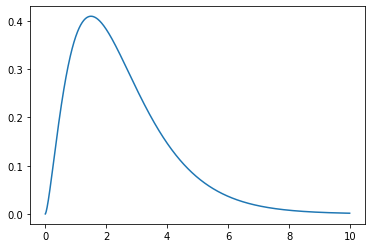

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot of the function
xplot = np.arange(0,10,0.01)
plt.plot(xplot,f(xplot))
plt.show()

In [5]:
# (ii) there are many other choices for the probability distribution
# for example we could take a half-Gaussian
# or a different exponential distribution, as in this example
# the important point is that we need to generate x-values in the correct domain: [0,inf]

nsteps = 10000
integral = 0

# using exponential distribution with a different parameter
def p(x):
    return np.exp(-x/2)/2

for i in range(nsteps):
    
    x = rn.exponential(2)
    integral += f(x)/p(x)    

integral = integral/nsteps
print("The integral equals: ", integral)
print("Exact value should be: ", exact_value)
print("Relative error w.r.t. exact value: ", abs(integral-exact_value)/exact_value)

The integral equals:  1.3259151085111964
Exact value should be:  1.329340388179137
Relative error w.r.t. exact value:  0.002576676145853335


In [27]:
# (iii) Markov chain with exponential probability distribution

nsteps = 1000000
x = 4
integral = 0

def p(x):
    # this ensures that if we happen to step outside of the range
    # the update is automatically rejected
    if x<0: 
        return 0
    else: 
        return np.exp(-x)

for i in range(nsteps):
    # how we change x is our choice
    xchange = rn.rand()-0.5
    xnew = x + xchange
    
    if p(xnew)/p(x) >= 1: 
        x = xnew
    else: 
        chance = rn.rand()
        if chance <= p(xnew)/p(x): 
            x = xnew
    integral += f(x)/p(x)
    
integral = integral/nsteps
print("The integral equals: ", integral)
print("Exact value should be: ", 3*np.sqrt(np.pi)/4)
print("Relative error w.r.t. exact value: ", abs(integral-exact_value)/exact_value)

The integral equals:  1.3508280949078346
Exact value should be:  1.329340388179137
Relative error w.r.t. exact value:  0.016164187080880292


## Exercise 3

(i) First we will run the regular code. The only adjustments that need to be made are for measuring the magnetization only after the system has equilibrated. 

In [9]:
# define the system parameters

L = 5      # size of lattice in each direction
J = 1       # interaction parameter
h = 0       # magnetic field
T = float(input("Please input the temperature: "))
beta = 1/T  # set k_B = 1

# define the state of the system: LxL grid with (initially) a random spin in each cell
config = 2*np.random.randint(2, size=(L,L))-1

# energy of a given state
def energy():  
    # elegant way of writing the sum over all nearest neighbors in the grid
    interaction = -J*( np.sum(config[0:L-1,:]*config[1:L,:]) +     # contributions of top/bottom neighbors
                       np.sum(config[:,0:L-1,]*config[:,1:L]))     # contributions of left/right neighbors
    
    magnetic = -h*np.sum(config)
    return interaction + magnetic

current_energy = energy()

# magnetization of a given state
def magnetization():
    return np.sum(config)/L/L

# Monte Carlo update using Metropolis algorithm
def update():
    
    global config, current_energy    # we want to be able to change the configuration
    
    # choose a random cell in the grid
    cell = np.random.randint(L, size=2)
    i = cell[0]
    j = cell[1]
    
    # calculate the current contribution of this cell to the total energy
    energy_cell = 0
    # be careful with the boundary
    if i != 0:   energy_cell += config[i-1, j]   # left neighbor
    if i != L-1: energy_cell += config[i+1, j]   # right neighbor
    if j != 0:   energy_cell += config[i, j-1]   # top neighbor
    if j != L-1: energy_cell += config[i, j+1]   # bottom neighbor
        
    # the current contribution to the interaction energy is: -J*energy_cell*config[i,j]
    # if we flip the spin, i.e. change config[i,j] to -config[i,j], the new contribution will also change sign
    # this means that overall:
    
    energy_difference = 2*J*energy_cell*config[i,j]
    
    # additional contribution due to the magnetic field
    energy_difference += 2*h*config[i,j]
    
    # check if update is accepted
    accept = False
    if energy_difference<0: 
        accept = True    # always accept updates that decrease the energy
    else:
        prob = np.exp(-beta*energy_difference)
        # standard to calculate event given a probability (see example biasedCoin() in Section 3.1.3)
        rand = np.random.rand()
        if rand<prob:
            accept = True
            
    # if update is accepted we flip the spin
    if accept == True:
        config[i, j] = -config[i, j]
        current_energy += energy_difference
    
    # keep track of the acceptance probability
    return accept

# set up the measurements
steps = int(1e6)
used = int(1e4)
skip = steps-used
magnetizationav = 0
accept_counter = 0

# run the simulation
for counter in range(steps):

    accept_counter += update()
    # measure magnetisation
    if counter > skip:
        magnetizationav += magnetization()
    
print("Average Magnetization: ", magnetizationav/float(used) )

Please input the temperature: 10
Average Magnetization:  -0.02671600000000007


Running the code above for $T=1$ we get an average magnetization of close to $+1$ or $-1$. This is because the system is in the ferromagnetic phase at low temperature. It wants to be in the lowest energy state, which means that all spins are aligned. The direction of alignment is arbitrary, because there is no external magnetic field.

Running the code above for $T=10$ we get an average magnetization of close to 0. This is because the system is in the paramagnetic phase at high temperature. It can "pay the energy cost" to be in a higher energy state, and the spins are essentially randomly distributed.

(ii) Now we will adjust the code for periodic boundary conditions (the results for the magnetization won't change for these temperatures)

In [11]:
# define the system parameters

L = 5       # size of lattice in each direction
J = 1       # interaction parameter
h = 0       # magnetic field
T = float(input("Please input the temperature: "))
beta = 1/T  # set k_B = 1

# define the state of the system: LxL grid with (initially) a random spin in each cell
config = 2*np.random.randint(2, size=(L,L))-1

# energy of a given state
def energy():  
    # this part changes
    interaction = -J*( np.sum(config[0:L-1,:]*config[1:L,:]) +     # contributions of top/bottom neighbors
                       np.sum(config[:,0:L-1,]*config[:,1:L])+     # contributions of left/right neighbors
                      np.sum(config[0,:]*config[-1,:])+np.sum(config[:,0]*config[:,-1]) )
    # the last line are contributions from the periodic boundary conditions
    
    magnetic = -h*np.sum(config)
    return interaction + magnetic

current_energy = energy()

# magnetization of a given state
def magnetization():
    return np.sum(config)/L/L

# Monte Carlo update using Metropolis algorithm
def update():
    
    global config, current_energy    # we want to be able to change the configuration
    
    # choose a random cell in the grid
    cell = np.random.randint(L, size=2)
    i = cell[0]
    j = cell[1]
    
    # calculate the current contribution of this cell to the total energy
    energy_cell = 0
    
    # this part needs to be adjusted to account for periodic boundary conditions
    if i != 0:   energy_cell += config[i-1, j]   # left neighbor
    else: energy_cell += config[i-1 + L, j]
        
    if i != L-1: energy_cell += config[i+1, j]   # right neighbor
    else: energy_cell += config[i+1 - L, j]  
        
    if j != 0:   energy_cell += config[i, j-1]   # top neighbor
    else: energy_cell += config[i, j-1+L]    
        
    if j != L-1: energy_cell += config[i, j+1]   # bottom neighbor
    else: energy_cell += config[i, j+1-L]    
        
    # the current contribution to the interaction energy is: -J*energy_cell*config[i,j]
    # if we flip the spin, i.e. change config[i,j] to -config[i,j], the new contribution will also change sign
    # this means that overall:
    
    energy_difference = 2*J*energy_cell*config[i,j]
    
    # additional contribution due to the magnetic field
    energy_difference += 2*h*config[i,j]
    
    # check if update is accepted
    accept = False
    if energy_difference<0: 
        accept = True    # always accept updates that decrease the energy
    else:
        prob = np.exp(-beta*energy_difference)
        # standard to calculate event given a probability (see example biasedCoin() in Section 3.1.3)
        rand = np.random.rand()
        if rand<prob:
            accept = True
            
    # if update is accepted we flip the spin
    if accept == True:
        config[i, j] = -config[i, j]
        current_energy += energy_difference
    
    # keep track of the acceptance probability
    return accept

# set up the measurements
steps = int(1e6)
used = int(1e4)
magnetizationav = 0
accept_counter = 0

# run the simulation
for counter in range(steps):

    accept_counter += update()
    # measure magnetisation
    if counter > skip:
        magnetizationav += magnetization()
    
print("Average Magnetization: ", magnetizationav/float(used) )

Please input the temperature: 1
Average Magnetization:  -0.9984680000000002
